<a href="https://colab.research.google.com/github/jbarnesspain/multitask_negation_for_targeted_sentiment/blob/master/notebooks/Speculation_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install git+git://github.com/jbarnesspain/multitask_negation_for_targeted_sentiment.git@master#egg=multitask_negation_target

In [2]:
from typing import List, Dict
from collections import defaultdict
from pathlib import Path
import tempfile

import requests
from sklearn.metrics import accuracy_score, f1_score
from multitask_negation_target.analysis import evaluation_metrics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', size=14)
matplotlib.rc('axes', titlesize=14)
matplotlib.rc('axes', labelsize=14)
matplotlib.rc('legend', fontsize=10)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
sns.set_style("whitegrid")

ROW_ORDER=['Test', 'Validation']
DATASET_ORDER = ['Laptop', 'Restaurant']
HUE_ORDER = ['STL', 'MTL (UPOS)', 'MTL (DR)', 'MTL (LEX)', 'MTL (CD)', 
             'MTL (SFU)', 'MTL (SPEC)']

def mean_std(data: pd.Series) -> str:
   to_percentage = data * 100
   return f'{np.mean(to_percentage):.2f} ({np.std(to_percentage):.2f})'

def create_twin_plot(data_df: pd.DataFrame) -> List[plt.Axes]:
  fig, axes = plt.subplots(1,2,figsize=(15, 5))
  dataset_list_order = ['Restaurant', 'Laptop']
  METRIC_ORDER = ['F1-i', 'Acc-s', 'F1-s', 'F1-a']
  for col_index, dataset_name in enumerate(dataset_list_order):
    df = data_df[data_df['Dataset']==dataset_name]
    axes[col_index] = sns.pointplot(join=False, dodge=0.8, ci='sd', y='Score', 
                                    hue='Model', x='Metric', data=df,
                                    hue_order=HUE_ORDER, order=METRIC_ORDER,
                                    ax=axes[col_index])
    axes[col_index].set_title(f'{dataset_name}')
    if col_index != 0:
      axes[col_index].set_ylabel('')
    if col_index != 0:
      axes[col_index].get_legend().remove()
    else:
      axes[col_index].legend(ncol=7, borderaxespad=0., 
                             bbox_to_anchor=(0.3, 1.1), loc='lower left')
  return axes

def get_speculation_data(filtered: bool, cwr: bool = False) -> Dict:

  speculation_results_df_dict = defaultdict(list)

  base_url = 'https://raw.githubusercontent.com/jbarnesspain/multitask_negation_for_targeted_sentiment/master/data/results/en'
  model_names = ['STL', 'MTL (CD)', 'MTL (SFU)', 'MTL (UPOS)', 'MTL (DR)', 'MTL (LEX)', 'MTL (SPEC)']
  dataset_names = ['Laptop', 'Restaurant', 'MAMS']
  dataset_name_mapper = {f'{name}_contextualized': name for name in dataset_names}
  if cwr:
    dataset_names = [f'{name}_contextualized' for name in dataset_names]

  for model_name in model_names:
    if model_name == 'STL':
      model_url = base_url + '/stl'
    elif model_name == 'MTL (CD)':
      model_url = base_url + '/mtl/conan_doyle'
    elif model_name == 'MTL (SFU)':
      model_url = base_url + '/mtl/sfu'
    elif model_name == 'MTL (SPEC)':
      model_url = base_url + '/mtl/sfu_spec'
    elif model_name == 'MTL (UPOS)':
      model_url = base_url + '/mtl/u_pos'
    elif model_name == 'MTL (DR)':
      model_url = base_url + '/mtl/dr'
    elif model_name == 'MTL (LEX)':
      model_url = base_url + '/mtl/lextag'
    for dataset_name in dataset_names:
      result_url = model_url + f'/{dataset_name.lower()}/dev_spec.conll'
      if filtered:
        result_url = model_url + f'/{dataset_name.lower()}/dev_spec_only.conll'
      if dataset_name == 'MAMS' or dataset_name == 'MAMS_contextualized':
        result_url = model_url + f'/{dataset_name}/dev_spec.conll'
        if filtered:
          result_url = model_url + f'/{dataset_name}/dev_spec_only.conll'
      for run_number in range(5):
        with tempfile.TemporaryDirectory() as temp_dir:
          temp_fp = Path(temp_dir, 'temp_file.txt')
          with temp_fp.open('w') as temp_file:
            temp_file.write(requests.get(result_url).text)
          f1_a = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                            ignore_sentiment=True)
          f1_a_recall, f1_a_precision, f1_a = f1_a
          f1_i = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                            ignore_sentiment=False)
          f1_i_recall, f1_i_precision, f1_i = f1_i
          f1_i_pos = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                ignore_sentiment=False, 
                                                filter_by_sentiment='POS')
          f1_i_pos_recall, f1_i_pos_precision, f1_i_pos = f1_i_pos
          f1_i_neu = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                ignore_sentiment=False, 
                                                filter_by_sentiment='NEU')
          f1_i_neu_recall, f1_i_neu_precision, f1_i_neu = f1_i_neu
          f1_i_neg = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                ignore_sentiment=False, 
                                                filter_by_sentiment='NEG') 
          f1_i_neg_recall, f1_i_neg_precision, f1_i_neg = f1_i_neg
          f1_s = evaluation_metrics.span_label_metric(temp_fp, run_number=run_number, 
                                                      metric_func=f1_score, 
                                                      average='macro')
          acc_s = evaluation_metrics.span_label_metric(temp_fp, run_number=run_number,
                                                      metric_func=accuracy_score)
          if cwr:
            speculation_results_df_dict['CWR'].append(True)
          else:
            speculation_results_df_dict['CWR'].append(False)
          speculation_results_df_dict['Model'].append(model_name)
          if dataset_name in dataset_name_mapper:
            speculation_results_df_dict['Dataset'].append(dataset_name_mapper[dataset_name])
          else:
            speculation_results_df_dict['Dataset'].append(dataset_name)
          speculation_results_df_dict['Run'].append(run_number)
          speculation_results_df_dict['F1-a'].append(f1_a)
          speculation_results_df_dict['F1-a-R'].append(f1_a_recall)
          speculation_results_df_dict['F1-a-P'].append(f1_a_precision)
          speculation_results_df_dict['F1-i'].append(f1_i)
          speculation_results_df_dict['F1-i-R'].append(f1_i_recall)
          speculation_results_df_dict['F1-i-P'].append(f1_i_precision)
          speculation_results_df_dict['F1-i-pos'].append(f1_i_pos)
          speculation_results_df_dict['F1-i-pos-R'].append(f1_i_pos_recall)
          speculation_results_df_dict['F1-i-pos-P'].append(f1_i_pos_precision)
          speculation_results_df_dict['F1-i-neg'].append(f1_i_neg)
          speculation_results_df_dict['F1-i-neg-R'].append(f1_i_neg_recall)
          speculation_results_df_dict['F1-i-neg-P'].append(f1_i_neg_precision)
          speculation_results_df_dict['F1-i-neu'].append(f1_i_neu)
          speculation_results_df_dict['F1-i-neu-R'].append(f1_i_neu_recall)
          speculation_results_df_dict['F1-i-neu-P'].append(f1_i_neu_precision)
          speculation_results_df_dict['F1-s'].append(f1_s)
          speculation_results_df_dict['Acc-s'].append(acc_s)
  return speculation_results_df_dict

# Significant Testing methods
from scipy import stats
def one_tailed_p_value(scores_1: List[float], scores_2: List[float], 
                       assume_normal: bool) -> float:
  '''
  :param scores_1: The scores e.g. list of accuracy values that reprsent one 
                    model/methods results (multiple scores can come from running 
                    the same model/method over different random seeds and/or 
                    dataset splits).
  :param scores_2: Same as `scores_1` but coming from a different method/model
  :param assume_normal: If the the scores are assumed to come from a normal 
                        distribution. See the following guide by 
                        `Dror and Reichart 2018 <https://arxiv.org/pdf/1809.01448.pdf>`_
                        to know if your metric/scores can be assumed to be normal or 
                        not. The test used when the scores are normal is the 
                        Welch’s t-test. When not normal it is the 
                        Wilcoxon signed-rank test.
  :returns: The p-value of a one-tailed test to determine if `scores_1` is 
            better than `scores_2`.
  '''
  p_value = -1.0
  if assume_normal:
    stat_result = stats.ttest_ind(scores_1, scores_2, equal_var=False, 
                                  nan_policy='raise')
    # one tailed hence why divided by 2
    p_value = stat_result.pvalue / 2
    # This is to take into account if the other is better
    if stat_result.statistic < 0:
      p_value = 1 - p_value
  else:
    stat_result = stats.wilcoxon(scores_1, scores_2, correction=False, 
                                  alternative='greater', zero_method='wilcox')
    p_value = stat_result.pvalue
  if p_value == -1.0:
    raise ValueError('P-Value was not calculated for these scores: '
                      f'score_1 {score_1} and scores_2 {scores_2} where '
                      f'the assumption of normality is {assume_normal}')
  return p_value

def create_p_value_results(metric_results: pd.DataFrame, 
                           p_value_threshold: float = 0.05,
                           keep_raw_p_value: bool = False
                           ) ->Dict[str, Dict[str, Dict[str, Dict[str, int]]]]:
  stats_metrics = metric_results['Metric'].unique().tolist()
  stats_datasets = metric_results['Dataset'].unique().tolist()
  stats_model_names = metric_results['Model'].unique().tolist()
  # Store whether or not one model is significantly better than another
  dataset_metric_model_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
  for dataset in stats_datasets:
    dataset_df = metric_results[metric_results['Dataset']==dataset]
    for metric in stats_metrics:
      metric_df = dataset_df[dataset_df['Metric']==metric]
      for model in stats_model_names:
        for compare_model in stats_model_names:
          if compare_model == model:
            dataset_metric_model_stats[dataset][metric][model][compare_model] = 0
          else:
            model_results = metric_df[metric_df['Model']==model]['Score'].tolist()
            compare_model_results = metric_df[metric_df['Model']==compare_model]['Score'].tolist()
            if metric == 'Acc-s':
              assume_normal = True
            else:
              assume_normal = False
            p_value = one_tailed_p_value(model_results, compare_model_results, 
                                        assume_normal=assume_normal)
            significant = 0
            if p_value <= p_value_threshold:
              significant = 1
            if keep_raw_p_value:
              dataset_metric_model_stats[dataset][metric][model][compare_model] = p_value
            else:
              dataset_metric_model_stats[dataset][metric][model][compare_model] = significant
  return dataset_metric_model_stats
  
def create_stats_heatmap(stats_dict: Dict[str, Dict[str, Dict[str, Dict[str, int]]]],
                         metric: str) -> List[List[plt.Axes]]:
  colorbar_values = [0, 1]
  cmap = sns.color_palette("hls", 2)
  vmin = 0
  vmax = 1
  dataset_list_order = ['Restaurant', 'Laptop']
  fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
  
  for col_index, dataset in enumerate(dataset_list_order):
    model_comparisons = stats_dict[dataset][metric]
    ax = axes[col_index]
    ax = sns.heatmap(pd.DataFrame(model_comparisons), cmap=cmap,linewidths=.5, 
                     ax=ax, vmin=vmin, vmax=vmax)
    ax.set_title(dataset)
    cb = ax.collections[-1].colorbar
    cb.set_ticks(colorbar_values)
    cb.set_ticklabels(['Not Significant', 'Significant'])
  return axes


def p_value_compared_to_stl(p_value_results: Dict[str, Dict[str, Dict[str, Dict[str, float]]]]
                            ) -> pd.DataFrame:
  datasets = []
  metrics = []
  models = []
  stl_p_values = []
  for dataset, metric_models in p_value_results.items():
    for metric, model_compare in metric_models.items():
      for model, compare in model_compare.items():
        if model == 'STL':
          continue
        stl_p_values.append(compare['STL'])
        datasets.append(dataset)
        metrics.append(metric)
        models.append(model)
  return pd.DataFrame({'Model': models, 'Metric': metrics, 'Dataset': datasets, 
                       'P Value': stl_p_values})
  
def p_value_compared_to_mtl(p_value_results: Dict[str, Dict[str, Dict[str, Dict[str, float]]]]
                            ) -> pd.DataFrame:
  datasets = []
  metrics = []
  models = []
  mtl_p_values = []
  for dataset, metric_models in p_value_results.items():
    for metric, model_compare in metric_models.items():
      for model, compare in model_compare.items():
        if model != 'STL':
          continue
        for compare_model in compare:
          if compare_model == 'STL':
            continue
          mtl_p_values.append(compare[compare_model])
          datasets.append(dataset)
          metrics.append(metric)
          models.append(compare_model)
  return pd.DataFrame({'Model': models, 'Metric': metrics, 'Dataset': datasets, 
                       'P Value': mtl_p_values})


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Evaluating for speculation

In this notebook we evaluate the different Targetted Sentiment Analysis (TSA) models. For more information about the models and the data see the [evaluation notebook for the main data.](https://github.com/jbarnesspain/multitask_negation_for_targeted_sentiment/blob/master/notebooks/Main_Evaluation.ipynb) In this notebook unlike the main data one we are only evaluating on the speculation version of the **Laptop** and **Restaurant** datasets.

The models will be compared across the following four metrics taken from [He et al. 2019](https://www.aclweb.org/anthology/P19-1048.pdf):
1. *F1-a* - F1 score of extracting the Target only ignoring the sentiment label.
2. *F1-i* - F1 score of extracting the Target and Sentiment label thus the combined/integrated task that is the TSA task.
3. *F1-s* - Macro F1 score of the sentiment labels for all correctly extracted targets.
4. *Acc-s* - Accuracy score of the sentiment labels for all correctly extracted targets.

This notebook is called the speculation evaluation as the data that is being used for evaluation from the Restaurant and Laptop datasets contain speculative samples only, where the speculation has been manually added by an annotator. Therefore the evaluation datasets contain fewer samples than the original development and test splits. The models that are being evaluated are the same as those in the [main data notebook](https://github.com/jbarnesspain/multitask_negation_for_targeted_sentiment/blob/master/notebooks/Main_Evaluation.ipynb) and thus use the original training and development datasets that do not contain any extra speculation samples.

The speculation results are in two halves. The first is on the speculative version of the datasets that still contain samples that have no speculation but overall the number of samples that contain speculation is much larger than the original, in this notebook the data will be called **Non-Filtered Speculation**. The second half only uses samples that have speculation, all the other samples are filtered out, in this notebook the data will be called **Filtered Speculation**.

Just like the [main data notebook](https://github.com/jbarnesspain/multitask_negation_for_targeted_sentiment/blob/master/notebooks/Main_Evaluation.ipynb) we will evaluate both the models using the GloVe and CWR embeddings.

## GloVe Results


Before any of the analysis can be done the data needs to be loaded and the metrics computed and then put into a DataFrame that has the following columns:
1. Model
2. Dataset
3. Run -- There are multiple runs for each model as each run uses a different random seed
5. CWR - Whether the embeddings are CWR or not. Not here would mean we are using the GloVe embeddings.
6. Metric
7. Score


In [3]:
speculation_results_df = pd.DataFrame(get_speculation_data(True, cwr=False))
not_metric_cols = ['Model', 'Dataset', 'Run', 'CWR']
metric_cols = [col_name for col_name in speculation_results_df.columns.tolist() 
               if col_name not in not_metric_cols]
speculation_results_df = pd.melt(speculation_results_df, id_vars=not_metric_cols, 
                              value_vars=metric_cols, var_name='Metric', 
                              value_name='Score')
speculation_results_df.head()

,Model,Dataset,Run,CWR,Metric,Score
0,STL,Laptop,0,False,F1-a,0.690476
1,STL,Laptop,1,False,F1-a,0.765152
2,STL,Laptop,2,False,F1-a,0.734082
3,STL,Laptop,3,False,F1-a,0.742647
4,STL,Laptop,4,False,F1-a,0.719697


### F1-i

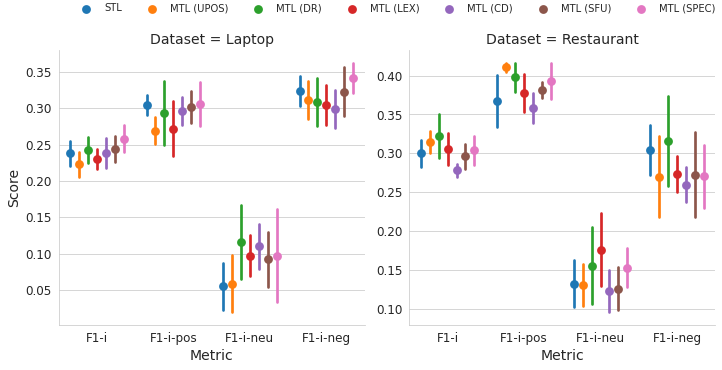

In [4]:
f1_i_order = ['F1-i', 'F1-i-pos', 'F1-i-neu', 'F1-i-neg']

f1_i_results = speculation_results_df[speculation_results_df['Metric'].isin(f1_i_order)]
ax=sns.catplot(data=f1_i_results, hue='Model', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.7, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_i_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.05, 0.98), 
                  loc='lower left')

### F1-a

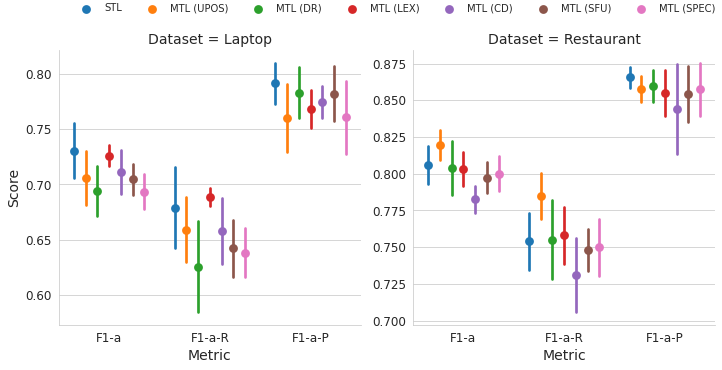

In [5]:
f1_a_order = ['F1-a', 'F1-a-R', 'F1-a-P']

f1_a_results = speculation_results_df[speculation_results_df['Metric'].isin(f1_a_order)]
ax=sns.catplot(data=f1_a_results, hue='Model', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.7, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_a_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.05, 0.98), 
                  loc='lower left')

### F1-s and Acc-s

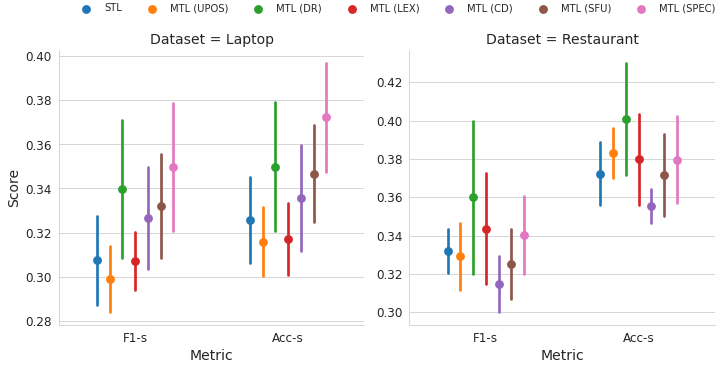

In [6]:
f1_s_order = ['F1-s', 'Acc-s']

f1_s_results = speculation_results_df[speculation_results_df['Metric'].isin(f1_s_order)]
ax=sns.catplot(data=f1_s_results, hue='Model', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.5, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_s_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.05, 0.98), 
                  loc='lower left')

### Headline Metric

These are the metrics that are shown in the paper and those that are the most important:
1. F1-I
2. F1-A
3. F1-S
4. Acc-S


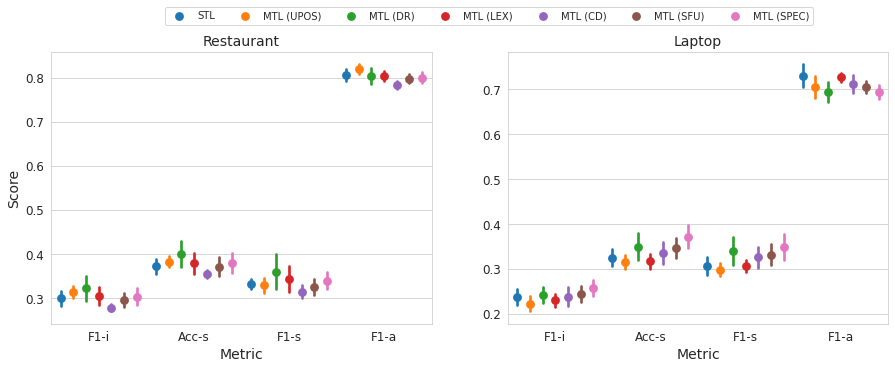

In [7]:
headline_metric_order = ['F1-i','F1-a','F1-s', 'Acc-s']
headline_results = speculation_results_df[speculation_results_df['Metric'].isin(headline_metric_order)]
_ = create_twin_plot(headline_results)

### Statistical Significance

As we can see from above the results vary sometimes the STL models are better than the MTL and vice versa therefore below we look at two different tests. The first is are the MTL models better than the STL models, and the second are the STL models better than the MTL.

#### MTL better than the STL

This is at 95% confidence: 

In [8]:
p_value_results = create_p_value_results(headline_results, keep_raw_p_value=True)
p_value_results = p_value_compared_to_stl(p_value_results)
pd.pivot_table(p_value_results, index=['Metric', 'Dataset'], 
               columns=['Model'], values='P Value').round(4) <=0.05

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Model              MTL (CD)  MTL (DR)  ...  MTL (SPEC)  MTL (UPOS)
Metric Dataset                         ...                        
Acc-s  Laptop         False     False  ...        True       False
       MAMS           False     False  ...       False       False
       Restaurant     False     False  ...       False       False
F1-a   Laptop         False     False  ...       False       False
       MAMS           False     False  ...       False       False
       Restaurant     False     False  ...       False       False
F1-i   Laptop         False     False  ...       False       False
       MAMS           False     False  ...       False       False
       Restaurant     False     False  ...       False       False
F1-s   Laptop         False     False  ...       False       False
       MAMS           False     False  ...       False       False
       Restaurant     False     False  ...       False       False

[12 rows x 6 columns]


#### STL better than the MTL

This is at 95% confidence: 

In [9]:
p_value_results = create_p_value_results(headline_results, keep_raw_p_value=True)
p_value_results = p_value_compared_to_mtl(p_value_results)
pd.pivot_table(p_value_results, index=['Metric', 'Dataset'], 
               columns=['Model'], values='P Value').round(4) <=0.05

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Model              MTL (CD)  MTL (DR)  ...  MTL (SPEC)  MTL (UPOS)
Metric Dataset                         ...                        
Acc-s  Laptop         False     False  ...       False       False
       MAMS            True     False  ...       False       False
       Restaurant     False     False  ...       False       False
F1-a   Laptop         False     False  ...        True        True
       MAMS           False     False  ...       False       False
       Restaurant      True     False  ...       False       False
F1-i   Laptop         False     False  ...       False        True
       MAMS            True      True  ...       False       False
       Restaurant      True     False  ...       False       False
F1-s   Laptop         False     False  ...       False       False
       MAMS            True     False  ...       False       False
       Restaurant      True     False  ...       False       False

[12 rows x 6 columns]

## CWR

In [10]:
cwr_speculation_results_df = pd.DataFrame(get_speculation_data(True, cwr=True))
not_metric_cols = ['Model', 'Dataset', 'Run', 'CWR']
metric_cols = [col_name for col_name in cwr_speculation_results_df.columns.tolist() 
               if col_name not in not_metric_cols]
cwr_speculation_results_df = pd.melt(cwr_speculation_results_df, id_vars=not_metric_cols, 
                                     value_vars=metric_cols, var_name='Metric', 
                                     value_name='Score')
cwr_speculation_results_df.head()

,Model,Dataset,Run,CWR,Metric,Score
0,STL,Laptop,0,True,F1-a,0.802974
1,STL,Laptop,1,True,F1-a,0.819188
2,STL,Laptop,2,True,F1-a,0.843636
3,STL,Laptop,3,True,F1-a,0.816176
4,STL,Laptop,4,True,F1-a,0.818182


### F1-i

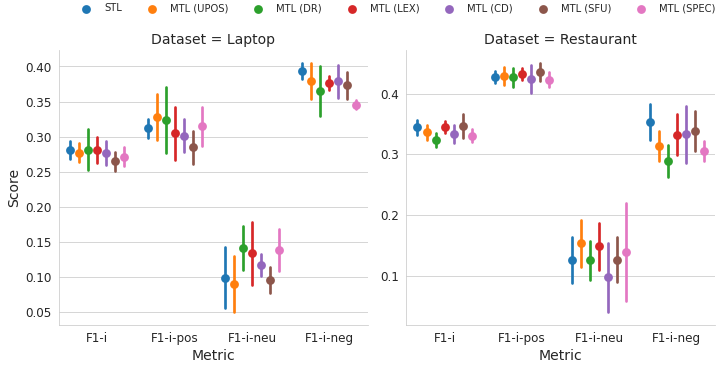

In [11]:
f1_i_order = ['F1-i', 'F1-i-pos', 'F1-i-neu', 'F1-i-neg']

f1_i_results = cwr_speculation_results_df[cwr_speculation_results_df['Metric'].isin(f1_i_order)]
ax=sns.catplot(data=f1_i_results, hue='Model', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.7, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_i_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.05, 0.98), 
                  loc='lower left')

### F1-a

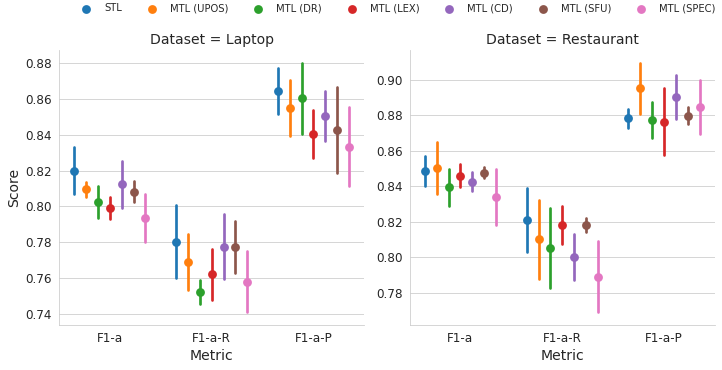

In [12]:
f1_a_order = ['F1-a', 'F1-a-R', 'F1-a-P']

f1_a_results = cwr_speculation_results_df[cwr_speculation_results_df['Metric'].isin(f1_a_order)]
ax=sns.catplot(data=f1_a_results, hue='Model', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.7, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_a_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.05, 0.98), 
                  loc='lower left')

### F1-s and Acc-s

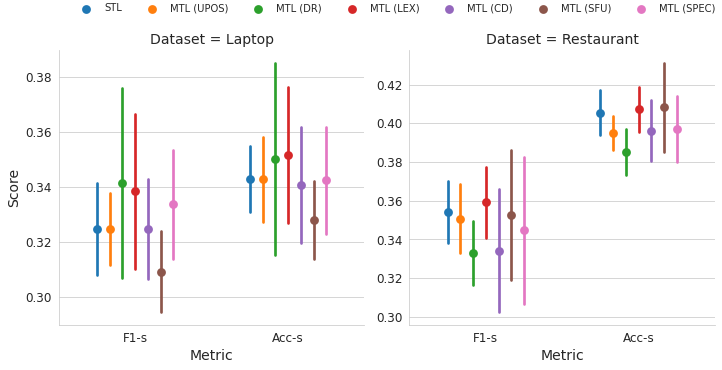

In [13]:
f1_s_order = ['F1-s', 'Acc-s']

f1_s_results = cwr_speculation_results_df[cwr_speculation_results_df['Metric'].isin(f1_s_order)]
ax=sns.catplot(data=f1_s_results, hue='Model', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.5, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_s_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.05, 0.98), 
                  loc='lower left')

### Headline Metric

These are the metrics that are shown in the paper and those that are the most important:
1. F1-I
2. F1-A
3. F1-S
4. Acc-S


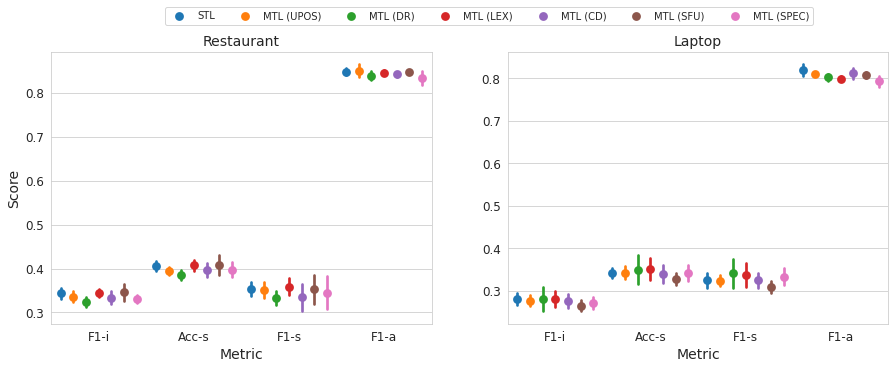

In [14]:
headline_metric_order = ['F1-i','F1-a','F1-s', 'Acc-s']
cwr_headline_results = cwr_speculation_results_df[cwr_speculation_results_df['Metric'].isin(headline_metric_order)]
_ = create_twin_plot(cwr_headline_results)

### Statistical Significance

As we can see from above the results vary sometimes the STL models are better than the MTL and vice versa therefore below we look at two different tests. The first is are the MTL models better than the STL models, and the second are the STL models better than the MTL.

#### MTL better than the STL

This is at 95% confidence: 

In [15]:
cwr_p_value_results = create_p_value_results(cwr_headline_results, keep_raw_p_value=True)
cwr_p_value_results = p_value_compared_to_stl(cwr_p_value_results)
pd.pivot_table(cwr_p_value_results, index=['Metric', 'Dataset'], 
               columns=['Model'], values='P Value').round(4)

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Model              MTL (CD)  MTL (DR)  ...  MTL (SPEC)  MTL (UPOS)
Metric Dataset                         ...                        
Acc-s  Laptop        0.5649    0.3522  ...      0.5137      0.5038
       MAMS          0.0352    0.0042  ...      0.0095      0.0621
       Restaurant    0.8150    0.9805  ...      0.7840      0.9047
F1-a   Laptop        0.8274    0.9310  ...      0.9661      0.8875
       MAMS          0.8274    0.5536  ...      0.8274      0.8875
       Restaurant    0.8875    0.8875  ...      0.8875      0.3429
F1-i   Laptop        0.4464    0.5536  ...      0.8274      0.7499
       MAMS          0.0398    0.0216  ...      0.3429      0.3429
       Restaurant    0.7499    0.9602  ...      0.9784      0.7499
F1-s   Laptop        0.5536    0.1125  ...      0.2501      0.4464
       MAMS          0.0398    0.0216  ...      0.0216      0.1125
       Restaurant    0.7499    0.8875  ...      0.6571      0.6571

[12 rows x 6 columns]


#### STL better than the MTL

This is at 95% confidence: 

In [16]:
cwr_p_value_results = create_p_value_results(cwr_headline_results, keep_raw_p_value=True)
cwr_p_value_results = p_value_compared_to_mtl(cwr_p_value_results)
pd.pivot_table(cwr_p_value_results, index=['Metric', 'Dataset'], 
               columns=['Model'], values='P Value').round(4)

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Model              MTL (CD)  MTL (DR)  ...  MTL (SPEC)  MTL (UPOS)
Metric Dataset                         ...                        
Acc-s  Laptop        0.4351    0.6478  ...      0.4863      0.4962
       MAMS          0.9648    0.9958  ...      0.9905      0.9379
       Restaurant    0.1850    0.0195  ...      0.2160      0.0953
F1-a   Laptop        0.1726    0.0690  ...      0.0339      0.1125
       MAMS          0.1726    0.4464  ...      0.1726      0.1125
       Restaurant    0.1125    0.1125  ...      0.1125      0.6571
F1-i   Laptop        0.5536    0.4464  ...      0.1726      0.2501
       MAMS          0.9602    0.9784  ...      0.6571      0.6571
       Restaurant    0.2501    0.0398  ...      0.0216      0.2501
F1-s   Laptop        0.4464    0.8875  ...      0.7499      0.5536
       MAMS          0.9602    0.9784  ...      0.9784      0.8875
       Restaurant    0.2501    0.1125  ...      0.3429      0.3429

[12 rows x 6 columns]

# Comparing GloVe and CWR model results

Below we plot the GloVe and CWR model results for the **F1-i**, **Acc-s**, and **F1-a** metrics:

In [19]:
combined_results = pd.concat([speculation_results_df, cwr_speculation_results_df])
combined_results = combined_results[combined_results['Metric'].isin(['F1-i','Acc-s', 'F1-s','F1-a'])]
combined_results = combined_results[combined_results['Dataset']!='MAMS']
pd.pivot_table(combined_results, values='Score', columns='Model', 
               index=['Dataset', 'Metric','CWR'], aggfunc=mean_std)

Model                        MTL (CD)      MTL (DR)  ...    MTL (UPOS)           STL
Dataset    Metric CWR                                ...                            
Laptop     Acc-s  False  33.56 (2.39)  35.00 (2.94)  ...  31.59 (1.57)  32.57 (1.94)
                  True   34.07 (2.11)  35.02 (3.50)  ...  34.27 (1.56)  34.28 (1.19)
           F1-a   False  71.10 (1.97)  69.42 (2.25)  ...  70.58 (2.46)  73.04 (2.48)
                  True   81.23 (1.30)  80.25 (0.90)  ...  80.95 (0.43)  82.00 (1.32)
           F1-i   False  23.88 (2.05)  24.26 (1.81)  ...  22.32 (1.73)  23.80 (1.77)
                  True   27.67 (1.68)  28.11 (2.92)  ...  27.74 (1.31)  28.12 (1.32)
           F1-s   False  32.66 (2.33)  33.99 (3.14)  ...  29.88 (1.50)  30.75 (2.02)
                  True   32.46 (1.82)  34.14 (3.47)  ...  32.45 (1.32)  32.47 (1.67)
Restaurant Acc-s  False  35.54 (0.90)  40.09 (2.95)  ...  38.32 (1.31)  37.23 (1.65)
                  True   39.61 (1.57)  38.50 (1.19)  ...  39.49 (0.89)  40.55 (1.16)
           F1-a   False  78.26 (0.92)  80.38 (1.86)  ...  81.98 (1.04)  80.59 (1.29)
                  True   84.25 (0.54)  83.93 (1.03)  ...  85.03 (1.47)  84.85 (0.83)
           F1-i   False  27.82 (0.79)  32.25 (2.79)  ...  31.43 (1.42)  30.02 (1.74)
                  True   33.38 (1.51)  32.31 (1.13)  ...  33.59 (1.20)  34.41 (1.23)
           F1-s   False  31.46 (1.47)  35.99 (3.98)  ...  32.92 (1.74)  33.18 (1.15)
                  True   33.42 (3.18)  33.28 (1.65)  ...  35.08 (1.78)  35.40 (1.59)

[16 rows x 7 columns]

# Extras

Below we show the statistical significance between each model. These heatmaps show whether or not the model in the X-axis is significantly better than the model on the Y-axis with a confidence of at least 95%.

## Statistical Tests for all the GloVe models

These are all of the significance results for the GloVe based models.

### F1-i

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


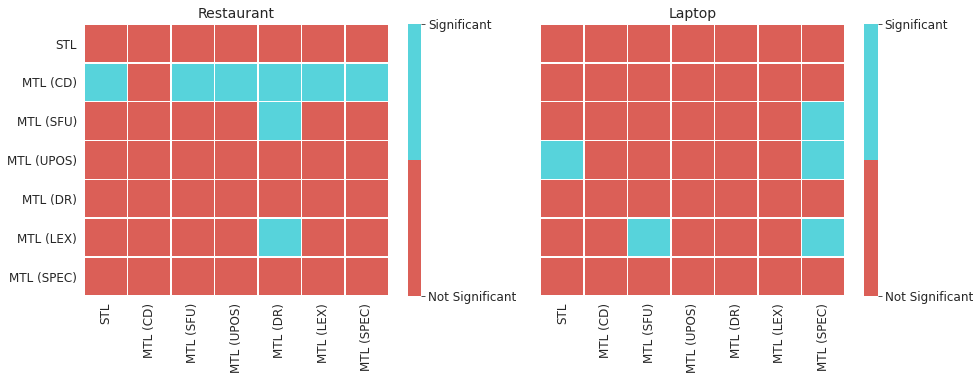

In [0]:
p_value_results = create_p_value_results(headline_results, p_value_threshold=0.05)
_ = create_stats_heatmap(p_value_results, metric='F1-i')

### F1-a

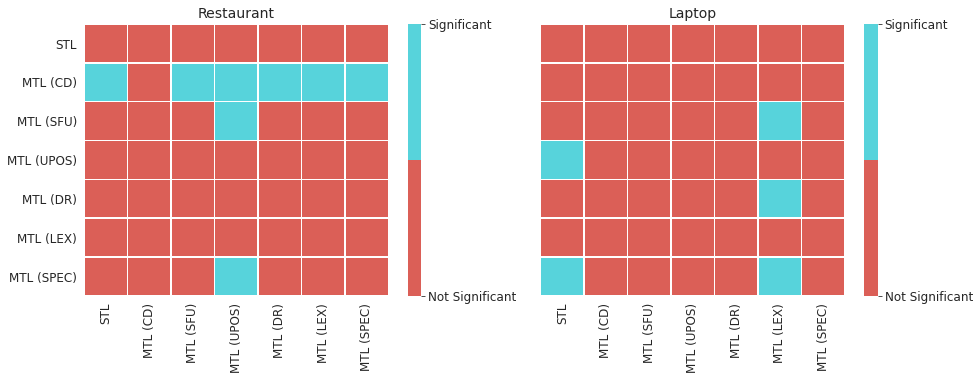

In [0]:
_ = create_stats_heatmap(p_value_results, metric='F1-a')

### F1-s

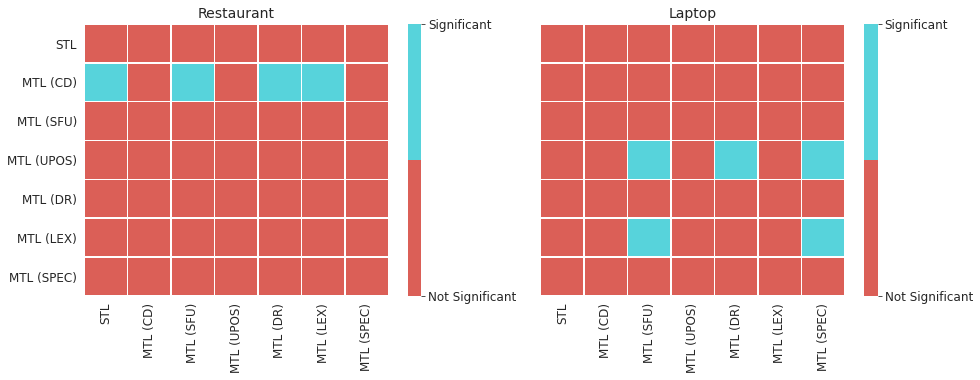

In [0]:
_ = create_stats_heatmap(p_value_results, metric='F1-s')

### Acc-s

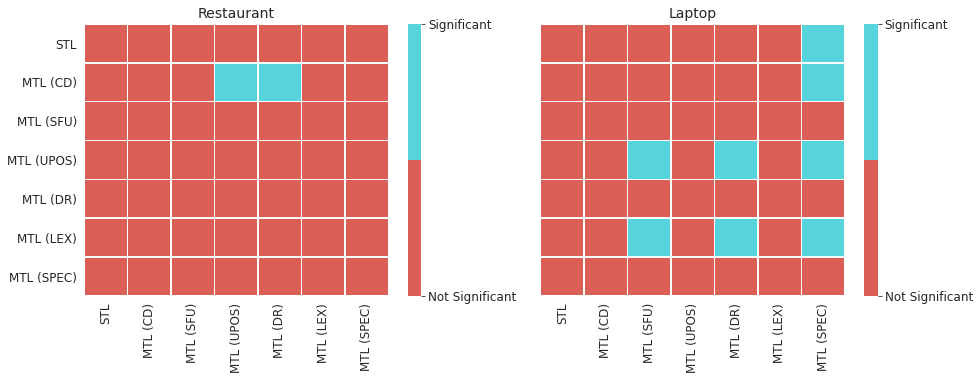

In [0]:
_ = create_stats_heatmap(p_value_results, metric='Acc-s')

## Statistical Tests for all the CWR models

These are all of the significance results for the CWR based models.

### F1-i

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


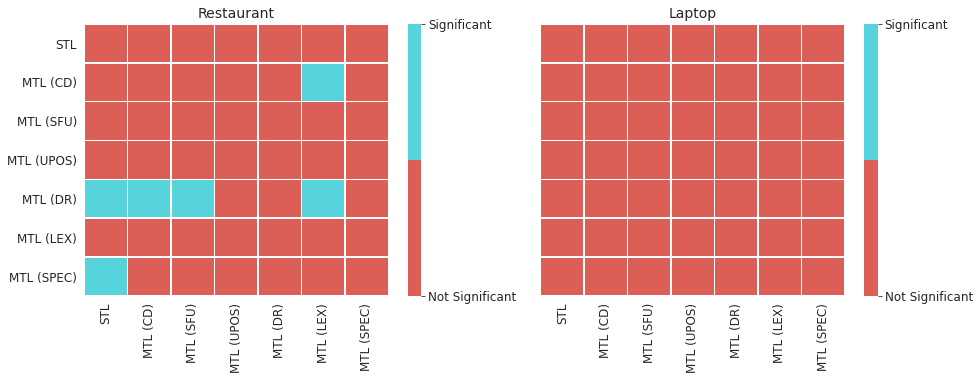

In [0]:
cwr_p_value_results = create_p_value_results(cwr_headline_results, p_value_threshold=0.05)
_ = create_stats_heatmap(cwr_p_value_results, metric='F1-i')

### F1-a

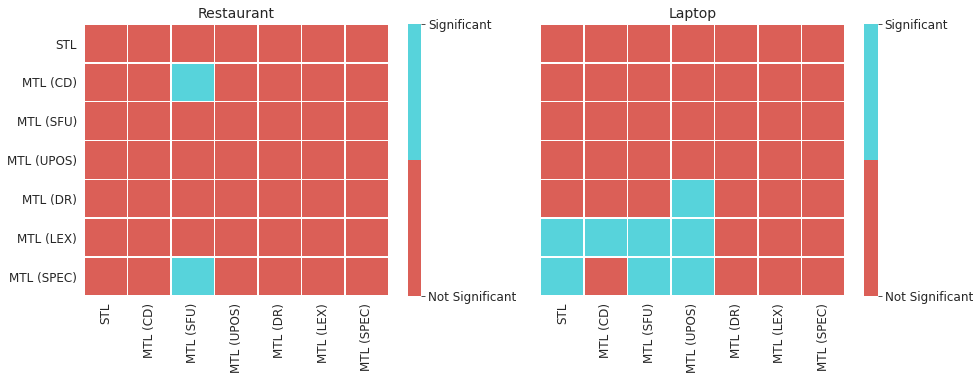

In [0]:
_ = create_stats_heatmap(cwr_p_value_results, metric='F1-a')

### F1-s

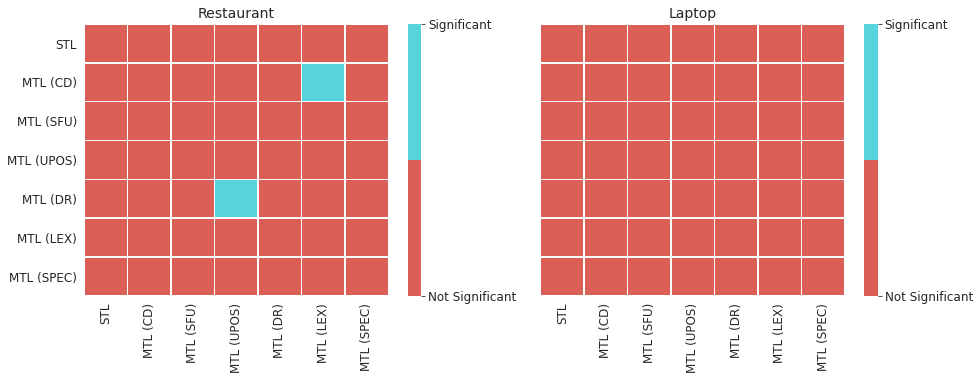

In [0]:
_ = create_stats_heatmap(cwr_p_value_results, metric='F1-s')

### Acc-s

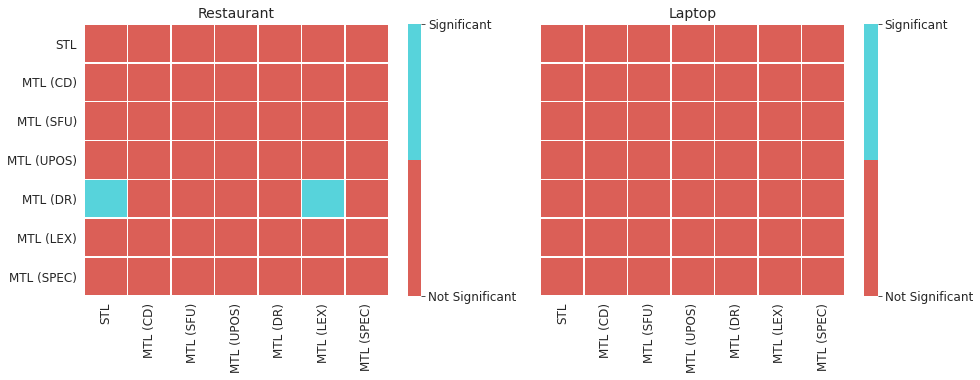

In [0]:
_ = create_stats_heatmap(cwr_p_value_results, metric='Acc-s')